In [1]:
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

# ---------------------------------------------------------------------
# 0. Normalized material properties (E=1)
# ---------------------------------------------------------------------
E = 1.0
NU = 0.25
LAM_K = NU / ((1 + NU) * (1 - 2 * NU))   # λ/E
MU_K  = 0.5 / (1 + NU)                    # μ/E
R_IN = 0.20

# ---------------------------------------------------------------------
# 1. Define MLP network
# ---------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1])
                                      for i in range(len(layers)-1)])
        self.activation = torch.tanh

    def forward(self, x):
        for lin in self.linears[:-1]:
            x = self.activation(lin(x))
        return self.linears[-1](x)

# ---------------------------------------------------------------------
# 2. PINN model with PDE and BC losses
# ---------------------------------------------------------------------
class KirschPINN(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return self.net(x)

    def pde_loss(self, x):
        x.requires_grad_(True)
        out = self.net(x)
        ux, uy = out[:,0:1], out[:,1:2]
        # Strains
        exx = torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0][:,0:1]
        eyy = torch.autograd.grad(uy, x, torch.ones_like(uy), create_graph=True)[0][:,1:2]
        exy = 0.5*(torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0][:,1:2]
                   + torch.autograd.grad(uy, x, torch.ones_like(uy), create_graph=True)[0][:,0:1])
        # Constitutive
        sxx = (2*MU_K + LAM_K)*exx + LAM_K*eyy
        syy = (2*MU_K + LAM_K)*eyy + LAM_K*exx
        sxy = 2*MU_K*exy
        # Equilibrium PDE residuals
        sxx_x = torch.autograd.grad(sxx, x, torch.ones_like(sxx), create_graph=True)[0][:,0:1]
        sxy_y = torch.autograd.grad(sxy, x, torch.ones_like(sxy), create_graph=True)[0][:,1:2]
        sxy_x = torch.autograd.grad(sxy, x, torch.ones_like(sxy), create_graph=True)[0][:,0:1]
        syy_y = torch.autograd.grad(syy, x, torch.ones_like(syy), create_graph=True)[0][:,1:2]
        f1 = sxx_x + sxy_y
        f2 = sxy_x + syy_y
        # net stresses
        s11_pred, s22_pred, s12_pred = out[:,2:3], out[:,3:4], out[:,4:5]
        # PDE losses: equilibrium + constitutive consistency
        loss_eq = ((f1**2 + f2**2).mean())
        loss_const = ((sxx - s11_pred)**2 + (syy - s22_pred)**2 + (sxy - s12_pred)**2).mean()
        return loss_eq + loss_const

    def bc_loss(self, xb):
        xb.requires_grad_(True)
        out = self.net(xb)
        ux, uy = out[:,0:1], out[:,1:2]
        s11, s22, s12 = out[:,2:3], out[:,3:4], out[:,4:5]
        # Identify boundary segments
        x, y = xb[:,0:1], xb[:,1:2]
        eps = 1e-3
        loss = 0.0
        # ux=0 on left (x=0)
        mask = (x < eps)
        if mask.sum()>0:
            loss += ((ux[mask])**2).mean()
        # uy=0 on bottom (y=0)
        mask = (y < eps)
        if mask.sum()>0:
            loss += ((uy[mask])**2).mean()
        # s11=-3 on right (x=1)
        mask = (x > 1-eps)
        if mask.sum()>0:
            loss += ((s11[mask] + 3.0)**2).mean()
            loss += ((s12[mask])**2).mean()
        # s22=-3 on top (y=1)
        mask = (y > 1-eps)
        if mask.sum()>0:
            loss += ((s22[mask] + 3.0)**2).mean()
            loss += ((s12[mask])**2).mean()
        # Hole traction-free: σ·n = 0
        # approximate hole: (x^2+y^2)=R_IN^2
        mask = ((x**2 + y**2) >= (R_IN**2 - eps)) & ((x**2 + y**2) <= (R_IN**2 + eps))
        if mask.sum()>0:
            theta = torch.atan2(y[mask], x[mask])
            # compute stresses on hole
            # recompute strains
            ux_h = ux[mask]; uy_h = uy[mask]
            exx = torch.autograd.grad(ux_h, xb, torch.ones_like(ux_h), create_graph=True)[0][:,0:1]
            eyy = torch.autograd.grad(uy_h, xb, torch.ones_like(uy_h), create_graph=True)[0][:,1:2]
            exy = 0.5*(torch.autograd.grad(ux_h, xb, torch.ones_like(ux_h), create_graph=True)[0][:,1:2]
                       + torch.autograd.grad(uy_h, xb, torch.ones_like(uy_h), create_graph=True)[0][:,0:1])
            sxx = (2*MU_K + LAM_K)*exx + LAM_K*eyy
            syy = (2*MU_K + LAM_K)*eyy + LAM_K*exx
            sxy = 2*MU_K*exy
            # radial unit vector
            nx, ny = torch.cos(theta), torch.sin(theta)
            tx = sxx*nx + sxy*ny
            ty = sxy*nx + syy*ny
            loss += (tx**2 + ty**2).mean()
        return loss

# ---------------------------------------------------------------------
# 3. Data generation
# ---------------------------------------------------------------------
# Domain points (inside plate minus hole)
def sample_domain(n):
    pts = []
    while len(pts) < n:
        x = torch.rand(n*2,2)
        valid = x[:,0]**2 + x[:,1]**2 >= R_IN**2
        pts.extend(x[valid].tolist())
        pts = pts[:n]
    return torch.tensor(pts, dtype=torch.float32)

# Boundary points (edges + hole)
def sample_boundary(n):
    n_edge = n // 5
    # edges: left, right, bottom, top (n_edge each), hole remainder
    ts = torch.rand(n_edge,1)
    left  = torch.cat([torch.zeros_like(ts), ts], dim=1)
    right = torch.cat([torch.ones_like(ts), ts], dim=1)
    bottom= torch.cat([ts, torch.zeros_like(ts)], dim=1)
    top   = torch.cat([ts, torch.ones_like(ts)], dim=1)
    n_hole = n - 4*n_edge
    theta  = 2*math.pi*torch.rand(n_hole,1)
    hole   = torch.cat([R_IN*torch.cos(theta), R_IN*torch.sin(theta)], dim=1)
    return torch.cat([left, right, bottom, top, hole], dim=0)

# Generate training points
n_domain   = 8000
n_boundary = 1000
x_domain   = sample_domain(n_domain)
x_boundary = sample_boundary(n_boundary)

# ---------------------------------------------------------------------
# 4. Setup and train
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Network and optimizer
    layer_cfg = [2] + [80]*5 + [5]
    net = MLP(layer_cfg)
    model = KirschPINN(net)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    epochs = 20000
    for epoch in range(1, epochs+1):
        loss_pde = model.pde_loss(x_domain)
        loss_bc  = model.bc_loss(x_boundary)
        loss = loss_pde + loss_bc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d} | PDE Loss: {loss_pde.item():.3e} | BC Loss: {loss_bc.item():.3e}")


Epoch  1000 | PDE Loss: 5.777e-02 | BC Loss: 1.090e-01
Epoch  2000 | PDE Loss: 3.917e-02 | BC Loss: 5.450e-02
Epoch  3000 | PDE Loss: 2.289e-02 | BC Loss: 3.665e-02
Epoch  4000 | PDE Loss: 3.083e-02 | BC Loss: 2.427e-02
Epoch  5000 | PDE Loss: 1.324e-02 | BC Loss: 2.218e-02
Epoch  6000 | PDE Loss: 1.127e-02 | BC Loss: 2.387e-02
Epoch  7000 | PDE Loss: 3.596e-02 | BC Loss: 2.300e-02
Epoch  8000 | PDE Loss: 1.137e-02 | BC Loss: 1.811e-02
Epoch  9000 | PDE Loss: 1.476e-02 | BC Loss: 1.954e-02
Epoch 10000 | PDE Loss: 9.105e-03 | BC Loss: 1.787e-02
Epoch 11000 | PDE Loss: 9.655e-03 | BC Loss: 1.918e-02
Epoch 12000 | PDE Loss: 7.031e-03 | BC Loss: 1.667e-02
Epoch 13000 | PDE Loss: 1.091e-02 | BC Loss: 1.613e-02
Epoch 14000 | PDE Loss: 7.197e-03 | BC Loss: 1.572e-02
Epoch 15000 | PDE Loss: 8.626e-03 | BC Loss: 1.707e-02
Epoch 16000 | PDE Loss: 6.889e-03 | BC Loss: 1.523e-02
Epoch 17000 | PDE Loss: 6.479e-03 | BC Loss: 1.546e-02
Epoch 18000 | PDE Loss: 6.769e-03 | BC Loss: 1.506e-02
Epoch 1900

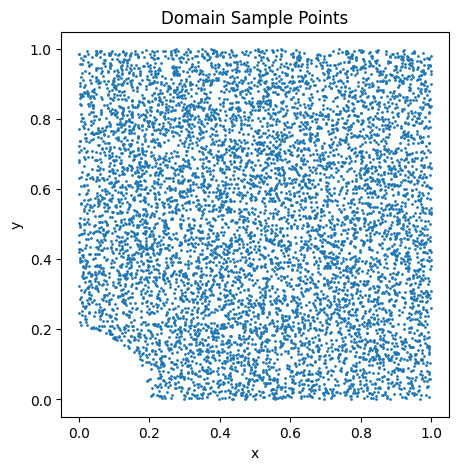

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(
    x_domain[:,0].detach().cpu().numpy(),
    x_domain[:,1].detach().cpu().numpy(),
    s=1
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Domain Sample Points')
plt.show()